![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [6]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [9]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [11]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [19]:
# Estadísticas descriptivas por temporada determinada
estadisticas_temporada = bikes.groupby('season')['total'].agg([
    'mean', 'std', 'min', 'max', 'median', 'count',
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 75)
])
estadisticas_temporada.rename(columns={'<lambda_0>': '25%', '<lambda_1>': '75%'}, inplace=True)

print("Estadísticas descriptivas por temporada determinada:")
print(estadisticas_temporada)

Estadísticas descriptivas por temporada determinada:
              mean         std  min  max  median  count   25%    75%
season                                                              
1       116.343261  125.273974    1  801    78.0   2686  24.0  164.0
2       215.251372  192.007843    1  873   172.0   2733  49.0  321.0
3       234.417124  197.151001    1  977   195.0   2733  68.0  347.0
4       198.988296  177.622409    1  948   161.0   2734  51.0  294.0


Al validar las estadísticas agrupadas por la variable (season) se encuentra que la temporada 3  es la que presenta un promedio más alto de bicicletas alquiladas. seguida por la temporda 2, sobre esto se puede inferir que corresponden a temporadas de verano y primavera en las cuales al ser más calidas se puede incentivar más el uso de bicicletas. También es posible observar que en los percentiles 25% y 75% los alquileres de bicicletas se encuentran en un rango más alto reforzando la idea de que estas son las temporadas con mayor actividad.

Por otro lado la temorada 1 presenta un menor promedio de uso que puede interpretarse como la temporada de invierno donde las condiciones del clima no son tan favorables para el uso de bicicleta.

In [15]:
# Estadísticas descriptivas por hora
estadisticas_hora = bikes.groupby('hour')['total'].agg([
    'mean', 'std', 'min', 'max', 'median', 'count',
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 75)
])
estadisticas_hora.rename(columns={'<lambda_0>': '25%', '<lambda_1>': '75%'}, inplace=True)

print("\nEstadísticas descriptivas por hora del día:")
print(estadisticas_hora)


Estadísticas descriptivas por hora del día:
            mean         std  min  max  median  count     25%     75%
hour                                                                 
0      55.138462   43.620012    2  283    41.0    455   24.00   74.50
1      33.859031   34.112105    1  168    19.0    454   11.00   46.00
2      22.899554   26.110267    1  119    11.0    448    5.00   32.00
3      11.757506   12.666442    1   66     6.0    433    3.00   15.00
4       6.407240    4.217633    1   28     6.0    442    3.00    9.00
5      19.767699   12.784293    1   57    19.0    452    8.00   29.00
6      76.259341   54.745333    1  213    75.0    455   24.50  118.00
7     213.116484  159.207044    1  596   208.0    455   63.00  334.00
8     362.769231  231.723065    8  839   392.0    455  133.50  563.50
9     221.780220   92.099209   14  414   217.0    455  161.00  294.50
10    175.092308  101.807629   17  539   149.0    455  106.00  218.50
11    210.674725  127.444294   10  647   183.

Al validar las estadísticas agrupadas por la variable (hour), se encuentra que hay 2 rangos de horas principales en el promedio de uso de los alquiles de bicicletas, el primero se encuentra entre las 7:00 y 9:00 a.m. y el otro rango es notorio entre las 4:00 y 7:00 p.m., esto puede interpretarse como las horas pico en las cuales las personas usan la bicicleta para desplazarse hacia y desde sus sitios de trabajo o de estudio.

Como puede esperarse, las horas de la madrugada entre las 0:00 y 5:00 a.m presentan un uso mucho menor. 

También es posible apreciar que la desviación estándar en las horas pico es muy alta mostrando una mayor variabilidad en esas horas del día lo cual puede estar explicado por factores externos como elclima o el día de la semana.

Todo lo anterior muestra que el uso de las bicicletas cambia de acuerdo a la temporada y hora del día.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

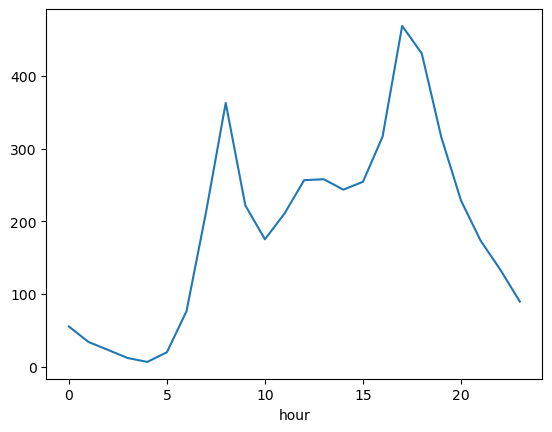

In [21]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

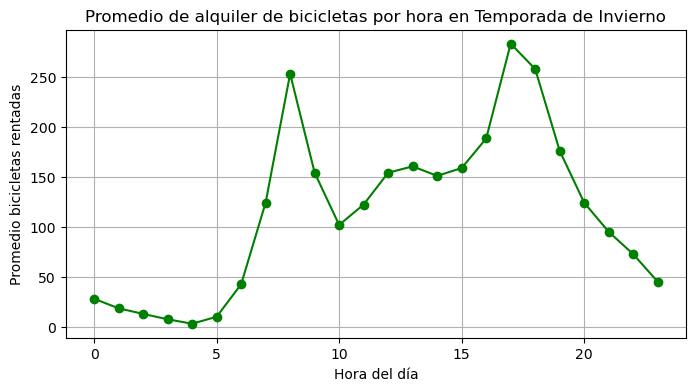

In [35]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 

import matplotlib.pyplot as plt  

# Filtro solo los datos del invierno
datos_invierno = bikes[bikes['season'] == 1]

# Calcular el promedio por hora
promedio_hora_invierno = datos_invierno.groupby('hour')['total'].mean()

# Generación de la gráfica por hora en invierno

plt.figure(figsize=(8,4))
plt.plot(promedio_hora_invierno, marker='o', color='green')
plt.title('Promedio de alquiler de bicicletas por hora en Temporada de Invierno')
plt.xlabel('Hora del día')
plt.ylabel('Promedio bicicletas rentadas')
plt.grid(True)
plt.show()


En la gráfica del promedio de alquiler de Bicicletas en la temporada de invierno, se observan 2 picos principales en el uso de bicicletas, el primero cerca de las 8:00 a.m y el otro entre las 5 y 6 p.m, esto indica que apesar del clima frio de invierno, muchas personas siguen usando la bicicleta como medio de transmporte para ir y volver de su trabajo o lugar de estudio.


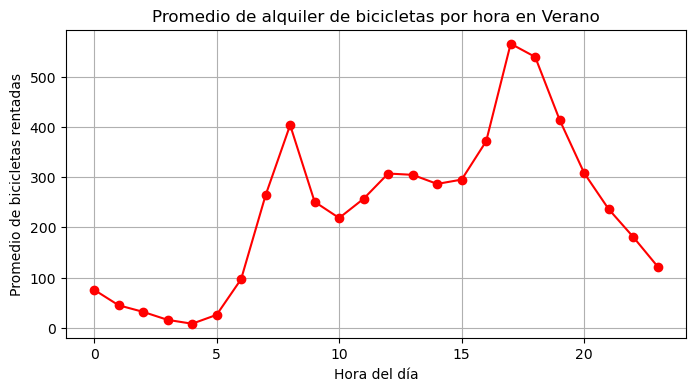

In [37]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 

# Filtro los datos de verano
datos_verano = bikes[bikes['season'] == 3]

# Calcular el promedio por hora
promedio_hora_verano = datos_verano.groupby('hour')['total'].mean()

# Generación la gráfica por hora en para verano

plt.figure(figsize=(8,4))
plt.plot(promedio_hora_verano, marker='o', color='red')
plt.title('Promedio de alquiler de bicicletas por hora en Verano')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de bicicletas rentadas')
plt.grid(True)
plt.savefig('bicicletas_verano.png', dpi=300)
plt.show()


En la gráfica del promedio de alquiler de Bicicletas en la temporada de Verano, también se observan 2 picos principales en el uso de bicicletas, el primero cerca de las 8:00 a.m y el otro entre las 5 y 6 p.m, sin embargo el número promedio de bicicletas rentadas en verano es muco mas alto que en temporada de Invierno, inclusive en horas de la tarde existe una mayor actividad.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [40]:
# Celda 3

# Importación de librerías
from sklearn.linear_model import LinearRegression
import pandas as pd

In [50]:
# Se transforma la variable categórica (season) en una variable dummy 
datos_con_dummies = pd.get_dummies(bikes, columns=['season'], drop_first=True)

# Definir las variables predictoras y la variable objetivo
X = datos_con_dummies[['hour', 'season_2', 'season_3', 'season_4']]
y = datos_con_dummies['total']

In [46]:
# Ajustar el modelo de regresión lineal

modelo_lineal = LinearRegression()
modelo_lineal.fit(X, y)

# Extraigo coeficientes e intercepto
coeficientes = pd.DataFrame({
    'Variable': ['Hora del día', 'Primavera (season_2)', 'Verano (season_3)', 'Otoño (season_4)'],
    'Coeficiente': modelo_lineal.coef_
})

intercepto = modelo_lineal.intercept_

In [48]:
# Imprimir coeficientes de los resultados
print('Intercepto del modelo:', intercepto)
print('\nCoeficientes asociados a cada variable:')
print(coeficientes)

Intercepto del modelo: -6.430262462305961

Coeficientes asociados a cada variable:
               Variable  Coeficiente
0          Hora del día    10.545206
1  Primavera (season_2)   100.317232
2     Verano (season_3)   119.467550
3      Otoño (season_4)    84.083118


El modelo de regresión lineal ajustado utiliza la variable (hour) y las estaciones del año como variables (dummy) para poder predecir la cantidad total de bicicletas rentadas; como el coeficiente de (hour) es positivo se encuentra que en promedio a medida que va avanzando el día la cantidad de bicicletas rentadas tiende a crecer, sin embargo esta relación no es lineal ya que como se evidenció anteriormente hay horas pico y horas valle.

En cuanto a las estaciones del año, como la variable (season) se transformó en dummie y se omitió para este ejercicio la temporada base (invierno), los coeficientes generados se interpretan con base en invierno: 

* Un coheficiente positivo en season 3 (verano) indica que en promedio se alquilan más bicicletas en vaerno que que invierno manteniendo constante la hora

Esto se confirma con el análisis del punto anterior, el verano es la estación con mayor actividad

¿Cuáles son las limitaciones de la regresión lineal en este caso?
En este caso se encuentra que no existe un comportamiento lineal por que el alquiler de bicicletas por hora tiene picos y valles lo cual no es completamente capturado mediante una regresión lineal por que el efecto de la hora puede depender de la estación.
Por otro lado no se contemplan otras variables que pueden tener incidencia como el clima, la temperatura, entre otros.


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [90]:
# Celda 4

# Árbol de decisión manual - Predicción sobre las variables "hour" y "season".

def arbol_decision_manual(fila):
    # raíz: división por hora
    if fila['hour'] < 8:
        
        # Subrama 1: hora menor a 8
        if fila['season'] == 1:
            return 100  # Nodo 1
        elif fila['season'] == 3:
            return 150  # Nodo 2
        else:
            return 120  # Nodo 3
    else:
        # Subrama 2: hora mayor o igual a 8
        if fila['hour'] < 17:
            if fila['season'] == 3:
                return 300  # Nodo 4
            elif fila['season'] == 4:
                return 250  # Nodo 5
            else:
                return 220  # Nodo 6
        else:
            if fila['season'] == 2:
                return 180  # Nodo 7
            else:
                return 200  # Nodo 8



Inicialmente se construyó un árbol de decisión simple usando divisiones manuales basadas en la hora del día (hour) y la estación (season). Empecé dividiendo entre horas antes y después de las 8 a.m., y luego se fué ajustando según la estación y el rango horario.

Cada hoja del árbol retorna un valor fijo estimado de total, que muestra el número promedio de bicicletas alquiladas en ese nodo. Los valores aproximaciones basadas en las tendencias vistas en los análisis de los puntos anteriores.

In [58]:
# Aplico el árbol manual para predecir el total
bikes['pred_manual'] = bikes.apply(arbol_decision_manual, axis=1)


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [60]:
# Celda 5

# Importación de modelos sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Creación variables dummy para 'season'
datos_arbol = pd.get_dummies(bikes, columns=['season'], drop_first=True)

# Definición de las variables predictoras y la variable respuesta
X = datos_arbol[['hour', 'season_2', 'season_3', 'season_4']]
y = datos_arbol['total']


In [62]:
# Dividir los datos en entrenamiento y validación para evitar sobre ajuste según lo mencionado en clase
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:
# Creación y entrenamiento del árbol de decisión
modelo_arbol = DecisionTreeRegressor(max_depth=4, min_samples_leaf=50, random_state=42)
modelo_arbol.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=50, random_state=42)

In [85]:
#EVALUAR EL DESEMPEÑO DEL ARBOL CREADO

# Predecir en el conjunto de validación
y_pred_arbol = modelo_arbol.predict(X_valid)

# Calcular RMSE
rmse_arbol = mean_squared_error(y_valid, y_pred_arbol, squared=False)
print(" El RMSE del árbol de decisión es :", rmse_arbol)


 El RMSE del árbol de decisión es : 133.4845134165811


In [81]:
#Compare desempeño con el modelo del punto 3

modelo_lineal_validacion = LinearRegression()
modelo_lineal_validacion.fit(X_train, y_train)

y_pred_lineal = modelo_lineal_validacion.predict(X_valid)
rmse_lineal = mean_squared_error(y_valid, y_pred_lineal, squared=False)
print("El RMSE de la regresión lineal es:", rmse_lineal)


El RMSE de la regresión lineal es: 159.9757265000345


Al realizar la comparación de los moedelos entrenados, se puede observar que el árbol de decisión tiene un mejor desempeño que la regresión lineal ya que su RMSE es menor (133.48 Vs 159.98). Esto muestra que el árbol se ajusta mejor a la variaciones de los datos por que puede capturar mejor las relacione NO lineales entre la hora del día y el número de bicicletas alquiladas.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [95]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [97]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [99]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [111]:
# Construya un árbol de decisión 

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# Crear el árbol de decisión con profundidad máxima
arbol = DecisionTreeClassifier(max_depth=5, random_state=1)
arbol.fit(X_train, y_train)

# Predicciones sobre el set de prueba
y_pred_arbol = arbol.predict(X_test)

# Evaluar desempeño en el árbol

accuracy_arbol = accuracy_score(y_test, y_pred_arbol)
f1_arbol = f1_score(y_test, y_pred_arbol)

print("Árbol de decisión - Métrica Accuracy:", accuracy_arbol)
print("Árbol de decisión - Métrica F1 Score:", f1_arbol)

# Regresión logística

from sklearn.linear_model import LogisticRegression

# Entrenar modelo 
log_reg = LogisticRegression(max_iter=1000, random_state=1)
log_reg.fit(X_train, y_train)

# Predicciones
y_pred_logreg = log_reg.predict(X_test)

# Evaluar desempeño de la regresión logística

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

print("Regresión logística - Métrica Accuracy:", accuracy_logreg)
print("Regresión logística - Métrica F1 Score:", f1_logreg)


Árbol de decisión - Métrica Accuracy: 0.6373333333333333
Árbol de decisión - Métrica F1 Score: 0.6616915422885573
Regresión logística - Métrica Accuracy: 0.6166666666666667
Regresión logística - Métrica F1 Score: 0.6015246015246014


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [147]:
# Imporatación de Libreria y creación de listas

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# Crear listas vacías para almacenar predicciones
preds_arbol_1 = []
preds_arbol_2 = []
preds_logreg = []


In [149]:
# Creamos el primer grupo – 100 árboles con max_depth=5

for i in range(100):
    # Hago muestreo bootstrap del set de entrenamiento
    X_sample, y_sample = resample(X_train, y_train, replace=True, random_state=i)
    
    # Árbol con profundidad fija
    modelo = DecisionTreeClassifier(max_depth=5, random_state=i)
    modelo.fit(X_sample, y_sample)
    
    # Predicción sobre el set de prueba
    pred = modelo.predict(X_test)
    preds_arbol_1.append(pred)


In [150]:
# Creamos el segundo grupo – 100 árboles con min_samples_leaf=10

for i in range(100, 200):
    X_sample, y_sample = resample(X_train, y_train, replace=True, random_state=i)
    
    modelo = DecisionTreeClassifier(min_samples_leaf=10, random_state=i)
    modelo.fit(X_sample, y_sample)
    
    pred = modelo.predict(X_test)
    preds_arbol_2.append(pred)

In [151]:
# Creamos el tercer grupo – 100 con regresiones logísticas

for i in range(200, 300):
    X_sample, y_sample = resample(X_train, y_train, replace=True, random_state=i)
    
    modelo = LogisticRegression(max_iter=1000, random_state=i)
    modelo.fit(X_sample, y_sample)
    
    pred = modelo.predict(X_test)
    preds_logreg.append(pred)

In [153]:
# Convertir listas a arrays para manejarlas como matrices

preds_arbol_1 = np.array(preds_arbol_1)
preds_arbol_2 = np.array(preds_arbol_2)
preds_logreg = np.array(preds_logreg)

# unir los modelos 
predicciones_totales = np.concatenate([preds_arbol_1, preds_arbol_2, preds_logreg], axis=0)

# Votación mayoritaria: para cada observación, sumamos las predicciones y tomamos la mayoría
from scipy.stats import mode
prediccion_final = (np.mean(predicciones_totales, axis=0) > 0.5).astype(int)


In [159]:
# Validación de cada modelo y su desempeño individual:

from sklearn.metrics import accuracy_score, f1_score

# Evaluación individual
pred_arbol_1 = (np.mean(preds_arbol_1, axis=0) > 0.5).astype(int)
pred_arbol_2 = (np.mean(preds_arbol_2, axis=0) > 0.5).astype(int)
pred_logreg  = (np.mean(preds_logreg, axis=0)  > 0.5).astype(int)

# Accuracy y F1
print("Modelo de Árboles max_depth:        - Accuracy:", accuracy_score(y_test, pred_arbol_1), "| F1:", f1_score(y_test, pred_arbol_1))
print("Modelo de Árboles min_samples_leaf: - Accuracy:", accuracy_score(y_test, pred_arbol_2), "| F1:", f1_score(y_test, pred_arbol_2))
print("Modelo de Regresiones logísticas:   - Accuracy:", accuracy_score(y_test, pred_logreg), "| F1:", f1_score(y_test, pred_logreg))


Modelo de Árboles max_depth:        - Accuracy: 0.6506666666666666 | F1: 0.6469002695417789
Modelo de Árboles min_samples_leaf: - Accuracy: 0.648 | F1: 0.6333333333333333
Modelo de Regresiones logísticas:   - Accuracy: 0.6146666666666667 | F1: 0.6019283746556474


In [133]:
# verificación final del ensamble realizado:

accuracy_ensamble = accuracy_score(y_test, prediccion_final)
f1_ensamble = f1_score(y_test, prediccion_final)

print("Ensamble completo (300 modelos) - Accuracy:", accuracy_ensamble)
print("Ensamble completo (300 modelos) - F1 Score:", f1_ensamble)


Ensamble completo (300 modelos) - Accuracy: 0.638
Ensamble completo (300 modelos) - F1 Score: 0.6283367556468172


Comparación de los resultados Obtenidos:

Al evaluar el desempeño de cada uno de los tres ensambles por separado, se encuentra que los árboles con profundidad controlada presentan un mejor desempeño, seguidos relativamente cerca por los árboles de control sobre el número demínimo de las hojas; la regresiones logísticas obtivieron el desempeño más bajo, lo cual ya se esperaba por tratarse de un problema no lineal.

el modelo de ensamble completo de los 300 modelos presenta in resultado intermedio por la combinación de los árboles con la estabilidad de la regresión pero no superó al mejor modelo individual. Se generó un F1 Score muy competitivo evidenciando que la votación mayoritaria si mejora la estabilidad de las predicciones por que redice la varianza.


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [165]:
peso_arbol_1 = f1_score(y_test, pred_arbol_1)  # ~0.647
peso_arbol_2 = f1_score(y_test, pred_arbol_2)  # ~0.633
peso_logreg  = f1_score(y_test, pred_logreg)   # ~0.602

In [173]:
#Calculamos la predicción final ponderada

# Combinamos las predicciones con pesos

ponderacion_total = (
    peso_arbol_1 * np.mean(preds_arbol_1, axis=0) +
    peso_arbol_2 * np.mean(preds_arbol_2, axis=0) +
    peso_logreg  * np.mean(preds_logreg, axis=0)
)

# Normalizar por la suma de pesos 
suma_pesos = peso_arbol_1 + peso_arbol_2 + peso_logreg
prediccion_ponderada = (ponderacion_total / suma_pesos > 0.5).astype(int)


In [176]:
#Evaluar el ensamble ponderado

accuracy_ponderado = accuracy_score(y_test, prediccion_ponderada)
f1_ponderado = f1_score(y_test, prediccion_ponderada)

print("Ensamble ponderado - Accuracy:", accuracy_ponderado)
print("Ensamble ponderado - F1 Score:", f1_ponderado)


Ensamble ponderado - Accuracy: 0.6406666666666667
Ensamble ponderado - F1 Score: 0.6300617707618393


En el caso de a votación ponderada se les asignó un mayor peso a los modelos más precisos según el F1 Score individual generado.
De esta forma el ensamble permite que se favorezcan las predicciones de los modelos más confiables. Al verificar el resultado final se evidenció un desempeño ligeramente superior el promedio simple (mayoría), esto muestra que ponderar por calidad puede servir cuando se tienen modelos con otros desempeños 

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

Al comparar el ensamble sobre el conjunto de 300 modelos realizado con votación mayoritaria y el ensamble ponderado, se observa que el segundo modelo generó un ligero aumento en las métricas , tanto en Accuracy como en F1 Score, El ensamble por mayoría alcanzó un Accuracy de 0.638 y un F1 Score de 0.628; El ensamble ponderado superó levemente estos valores, con un Accuracy de 0.641 y un F1 Score de 0.630.

Comparación de resultados finales (Puntos 7 y 8):

| Modelo                      | Accuracy | F1 Score |
|-----------------------------|----------|----------|
| Votación Mayoritaria     | 0.638    | 0.628    |
| Votación Ponderada    | 0.641    | 0.630    |


* Método de votación Mayoritaria:

Ventajas: Es sencillo de implementar, reduce la varianza
Desventaja: Trata todos los modelos como iguales, incluso si su desempeño varía

* Método de votación Ponderada:
  
Ventajas: considera el desempeño individual de cada modelo, mejora el balance si hay modelos más confiables.
Desventajas: Se necesita calcular los pesos
